<a href="https://colab.research.google.com/github/naoya1110/road_following_by_regression/blob/main/train_model_resnet18_trt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Road Following by Regression - Train Model ResNet18

## Introduction
After you finished data collection for you road following task, you need to train a model with your dataset. In this notebook, we will train ResNet18 model with the dataset. After finished training, we will convert the native PyTorch ResNet18 model to a TensorRT model.

### GPU
Please make sure we can use a GPU for model training.

In [1]:
import torch

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(device)

cuda


### Basic Python Packages
Let's import basic Python packages.

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm.notebook import tqdm
import shutil
import glob
import PIL.Image

## Data Preparation

### Upload & Extract Dataset

We need to upload the `dataset_reg.zip` file in the file browser of the Google Colab. This takes time depending the size of your dataset. After uploading is finished, you can extract it with the next command.

In [ ]:
! unzip -q dataset_reg.zip

Now we should see a directory named ``dataset_reg`` in the file browser.

***If your `dataset_reg.zip` file is in your google drive***

First you need to mount your google drive with the next command.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Then extract the `dataset_reg.zip` file. Remenber to change the file path appropriate for your `dataset_reg.zip`.

In [ ]:
!unzip -q /path/to/your/dataset_reg.zip

In [5]:
!unzip -q /content/drive/MyDrive/lectures/2022_AI_Robotics_Lab/Part2/road_following_by_regression/dataset_reg.zip

### Remove Broken Data
The dataset may contain some broken image data or unnecessary directories for some reasons. Such data will cause errors when we train the model. So it is better to remove those data before training.

In [6]:
dataset_dir = "dataset_reg"
filenames = sorted(os.listdir(dataset_dir))

for filename in filenames:
    path = os.path.join(dataset_dir, filename)
    img = cv2.imread(path)
    if img is None:
        try:
            os.remove(path)
            print("Removed", path)
        except IsADirectoryError:
            shutil.rmtree(path)
            print("Removed", path)

### Create Dataset
Now we use the ``ImageFolder`` dataset class available with the ``torchvision.datasets`` package.  We attach transforms from the ``torchvision.transforms`` package to prepare the data for training.  

In [7]:
import torch
import torchvision.transforms as transforms

def get_x(path, width):
    """Gets the x value from the image filename"""
    return float(int(path.split("_")[3])) / width

def get_y(path, height):
    """Gets the y value from the image filename"""
    return float(int(path.split("_")[4])) / height

means = [0.485, 0.456, 0.406]
stds = [0.229, 0.224, 0.225]

class RegDataset(torch.utils.data.Dataset):
    
    def __init__(self, directory):
        self.directory = directory
        self.image_paths = glob.glob(os.path.join(self.directory, '*.jpg'))
        self.color_jitter = transforms.ColorJitter(0.1, 0.1, 0.1, 0.1)
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        
        image = PIL.Image.open(image_path)
        width, height = image.size
        x = float(get_x(os.path.basename(image_path), width))
        y = float(get_y(os.path.basename(image_path), height))

        image = self.color_jitter(image)
        image = transforms.functional.resize(image, (224, 224))
        image = transforms.functional.to_tensor(image)
        image = image.numpy()[::-1].copy()
        image = torch.from_numpy(image)
        image = transforms.functional.normalize(image, means, stds)
        
        return image, torch.tensor([x, y]).float()
    
dataset = RegDataset('dataset_reg')
print("Number of data:", len(dataset))

Number of data: 3504


### Data Distribution
Let's visualize the distribution of x and y data.

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


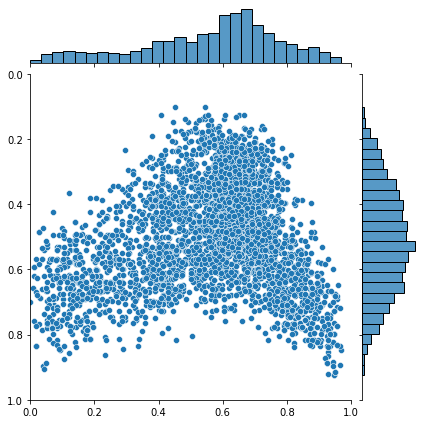

In [8]:
x_list = []
y_list = []
for i in range(len(dataset)):
    _, xy = dataset[i]
    x_list.append(xy[0])
    y_list.append(xy[1])

sns.jointplot(np.array(x_list), np.array(y_list), xlim=(0, 1), ylim=(1, 0))

### Train Test Split
We need to split the dataset for training and testing.

In [9]:
test_size = 200
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [len(dataset) - test_size, test_size])

### Data Loaders
Then we can make data loaders for the training and testing datasets.

In [10]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=50,
    shuffle=True,
    num_workers=2
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=50,
    shuffle=False,
    num_workers=2
)

## Model Building

### Model Architecture
We will use ResNet18 pretrained model. We replace the final linear layer so that we can have two output neurons for predicting x and y values.

In [11]:
import torchvision.models as models
model = models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(512, 2)
device = torch.device('cuda')
model = model.to(device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

### torchinfo

In [12]:
! pip install torchinfo
from torchinfo import summary

for x_batch, _ in train_loader:
    break

input_shape = x_batch.shape
print(input_shape)

summary(model, input_shape)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
torch.Size([50, 3, 224, 224])


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [50, 2]                   --
├─Conv2d: 1-1                            [50, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [50, 64, 112, 112]        128
├─ReLU: 1-3                              [50, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [50, 64, 56, 56]          --
├─Sequential: 1-5                        [50, 64, 56, 56]          --
│    └─BasicBlock: 2-1                   [50, 64, 56, 56]          --
│    │    └─Conv2d: 3-1                  [50, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-2             [50, 64, 56, 56]          128
│    │    └─ReLU: 3-3                    [50, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [50, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-5             [50, 64, 56, 56]          128
│    │    └─ReLU: 3-6                    [50, 64, 56, 56]          --
│

## Training

### Training Loop

Now we can train the model. Since this is a regresion model we are going to use `MSELoss()` as the loss function.

In [13]:
import torch.optim as optim
import torch.nn as nn

model = models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(512, 2)
device = torch.device('cuda')
model = model.to(device)

loss_func = nn.MSELoss()                      # use MSE loss function.
optimizer = optim.Adam(model.parameters(), lr=1E-4)    # set optimizer
epochs = 30

best_model_path = 'best_model_reg_resnet18.pth'
best_loss = 1E+9

# create empty lists for saving metrics during training
train_loss_list = []
test_loss_list = []

for epoch in range(epochs):
    print("-----------------------------")
    print(f"Epoch {epoch+1}/{epochs}")

    # initialize metrics
    train_loss = 0
    test_loss = 0

    #--- Training Phase ---#
    model.train()    # set model to training mode

    pbar = tqdm(train_loader)
    pbar.set_description("Train")

    for x_batch, y_batch in pbar:      # take mini batch data from train_loader
        
        x_batch = x_batch.to(device)     # load x_batch data on GPU
        y_batch = y_batch.to(device)     # load y_batch data on GPU
    
        optimizer.zero_grad()                  # reset gradients to 0
        p_batch = model(x_batch)               # do prediction
        loss = loss_func(p_batch, y_batch)     # measure loss
        loss.backward()                        # calculate gradients
        optimizer.step()                       # update model parameters

        train_loss += loss.item()                                # accumulate loss value

        pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    #----------------------#

    #--- Evaluation Phase ---#
    with torch.no_grad():   # disable autograd for saving memory usage
        model.eval()        # set model to evaluation mode

        pbar = tqdm(test_loader)
        pbar.set_description("Test") 

        for x_batch, y_batch in pbar:   # take mini batch data from test_loader

            x_batch = x_batch.to(device)     # load x_batch data on GPU
            y_batch = y_batch.to(device)     # load y_batch data on GPU

            p_batch = model(x_batch)              # do prediction
            loss = loss_func(p_batch, y_batch)    # measure loss

            test_loss += loss.item()                                # accumulate loss value
            p_batch_label = torch.argmax(p_batch, dim=1)            # convert p_batch vector to p_batch_label

            pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    #------------------------#

    train_loss = train_loss/len(train_loader)                 # determine loss for training data
    test_loss = test_loss/len(test_loader)                    # determine loss for test data 

    # show and store metrics
    print(f"Train Loss={train_loss:.5f}, Test Loss={test_loss:.5f}")

    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)

    # save the model if test accuracy is better than before
    if test_loss < best_loss:
        torch.save(model.state_dict(), best_model_path)
        print(f"Test loss decreased from {best_loss:.3f} to {test_loss:.3f}")
        print(f"Model saved at {best_model_path}")
        best_loss = test_loss

-----------------------------
Epoch 1/30


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss=0.06220, Test Loss=0.02809
Test loss decreased from 1000000000.000 to 0.028
Model saved at best_model_reg_resnet18.pth
-----------------------------
Epoch 2/30


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss=0.01195, Test Loss=0.01787
Test loss decreased from 0.028 to 0.018
Model saved at best_model_reg_resnet18.pth
-----------------------------
Epoch 3/30


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss=0.00755, Test Loss=0.00940
Test loss decreased from 0.018 to 0.009
Model saved at best_model_reg_resnet18.pth
-----------------------------
Epoch 4/30


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss=0.00582, Test Loss=0.00959
-----------------------------
Epoch 5/30


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss=0.00451, Test Loss=0.00901
Test loss decreased from 0.009 to 0.009
Model saved at best_model_reg_resnet18.pth
-----------------------------
Epoch 6/30


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss=0.00415, Test Loss=0.00888
Test loss decreased from 0.009 to 0.009
Model saved at best_model_reg_resnet18.pth
-----------------------------
Epoch 7/30


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss=0.00348, Test Loss=0.00667
Test loss decreased from 0.009 to 0.007
Model saved at best_model_reg_resnet18.pth
-----------------------------
Epoch 8/30


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss=0.00351, Test Loss=0.00719
-----------------------------
Epoch 9/30


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss=0.00279, Test Loss=0.00698
-----------------------------
Epoch 10/30


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss=0.00227, Test Loss=0.00660
Test loss decreased from 0.007 to 0.007
Model saved at best_model_reg_resnet18.pth
-----------------------------
Epoch 11/30


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss=0.00231, Test Loss=0.00634
Test loss decreased from 0.007 to 0.006
Model saved at best_model_reg_resnet18.pth
-----------------------------
Epoch 12/30


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss=0.00196, Test Loss=0.00558
Test loss decreased from 0.006 to 0.006
Model saved at best_model_reg_resnet18.pth
-----------------------------
Epoch 13/30


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss=0.00193, Test Loss=0.00611
-----------------------------
Epoch 14/30


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss=0.00183, Test Loss=0.00812
-----------------------------
Epoch 15/30


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss=0.00185, Test Loss=0.00562
-----------------------------
Epoch 16/30


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss=0.00155, Test Loss=0.00717
-----------------------------
Epoch 17/30


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss=0.00144, Test Loss=0.00573
-----------------------------
Epoch 18/30


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss=0.00160, Test Loss=0.00592
-----------------------------
Epoch 19/30


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss=0.00152, Test Loss=0.00552
Test loss decreased from 0.006 to 0.006
Model saved at best_model_reg_resnet18.pth
-----------------------------
Epoch 20/30


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss=0.00132, Test Loss=0.00613
-----------------------------
Epoch 21/30


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss=0.00141, Test Loss=0.00599
-----------------------------
Epoch 22/30


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss=0.00115, Test Loss=0.00642
-----------------------------
Epoch 23/30


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss=0.00145, Test Loss=0.00560
-----------------------------
Epoch 24/30


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss=0.00119, Test Loss=0.00543
Test loss decreased from 0.006 to 0.005
Model saved at best_model_reg_resnet18.pth
-----------------------------
Epoch 25/30


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss=0.00119, Test Loss=0.00648
-----------------------------
Epoch 26/30


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss=0.00177, Test Loss=0.00694
-----------------------------
Epoch 27/30


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss=0.00179, Test Loss=0.00605
-----------------------------
Epoch 28/30


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss=0.00153, Test Loss=0.00530
Test loss decreased from 0.005 to 0.005
Model saved at best_model_reg_resnet18.pth
-----------------------------
Epoch 29/30


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss=0.00109, Test Loss=0.00542
-----------------------------
Epoch 30/30


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss=0.00102, Test Loss=0.00534


### Learning Curves
Let's check the learning curves.

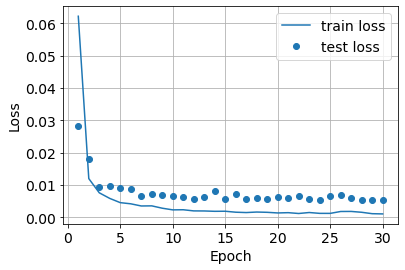

In [14]:
plt.rcParams["font.size"]=14
real_epochs = np.arange(len(train_loss_list))+1

plt.plot(real_epochs, train_loss_list, c="#1f77b4", label="train loss")
plt.plot(real_epochs, test_loss_list, lw=0, marker="o", c="#1f77b4", label="test loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()

## Evaluation

### Load The Best Model
Let's load the best model parameters.

In [15]:
model.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

Text(0.5, 1.0, 'y position')

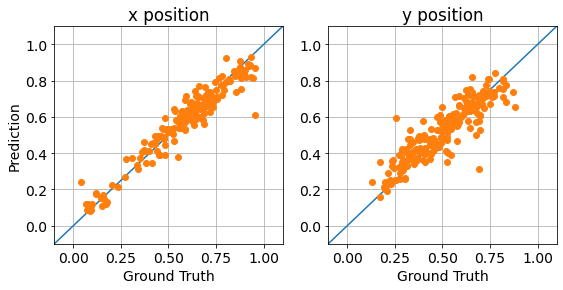

In [16]:
truths = []
preds = []

with torch.no_grad():   # disable autograd for saving memory usage
    model.eval()        # set model to evaluation mode

    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)     # load x_batch data on GPU
        p_batch = model(x_batch)    # predict

        p_batch = p_batch.to("cpu").numpy()
        y_batch = y_batch.to("cpu").numpy()
        preds.append(p_batch)
        truths.append(y_batch)

preds = np.array(preds).reshape(test_size, 2)
truths = np.array(truths).reshape(test_size, 2)

plt.figure(figsize=(9, 4))

plt.subplot(1, 2, 1)
plt.plot([-1.2, 1.2], [-1.2, 1.2])
plt.plot(truths[:,0], preds[:,0], lw=0, marker="o")
plt.grid()
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)
plt.xlabel("Ground Truth")
plt.ylabel("Prediction")
plt.title("x position")

plt.subplot(1, 2, 2)
plt.plot([-1.2, 1.2], [-1.2, 1.2])
plt.plot(truths[:,1], preds[:,1], lw=0, marker="o")
plt.grid()
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)
plt.xlabel("Ground Truth")
plt.title("y position")

### Predictions for Test Data
Let's see the predictions for the test dataset.

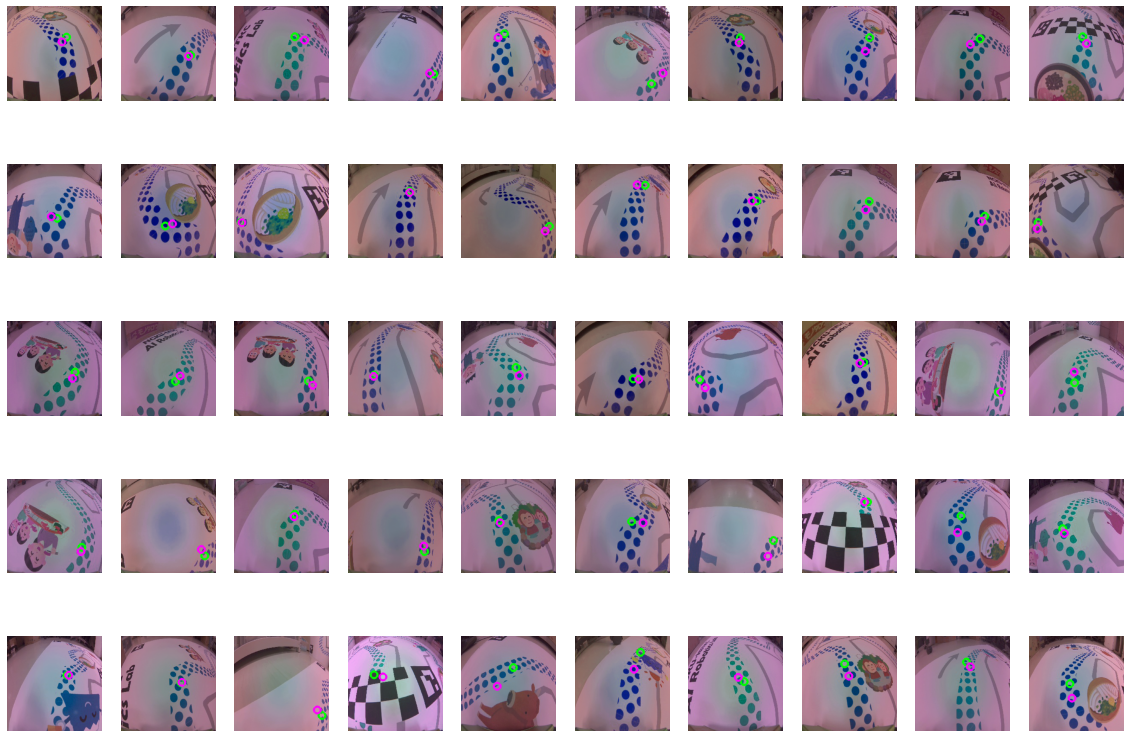

In [17]:
plt.figure(figsize=(20, 14))

for i in range(50):
    image, xy = test_dataset[i]
    image = np.transpose(image, (1,2,0))
    
    image[:, :, 0] = image[:, :, 0]*stds[0]+means[0]
    image[:, :, 1] = image[:, :, 1]*stds[1]+means[1]
    image[:, :, 2] = image[:, :, 2]*stds[2]+means[2]
    image = (255*image).numpy().astype("uint8")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    xy_truth = tuple((truths[i]*224).astype("int"))
    xy_pred = tuple((preds[i]*224).astype("int"))

    plt.subplot(5, 10, i+1)
    image = cv2.circle(image, xy_truth, 8, (0,255, 0), 3)
    image = cv2.circle(image, xy_pred, 8, (255, 0, 255), 3)
    plt.imshow(image)
    plt.axis("off")

## Build TensorRT Model

### Setup TensorRT environment
We need to setup the environment for TensorRT.

In [ ]:
! pip install nvidia-tensorrt
%cd /content
! git clone https://github.com/NVIDIA-AI-IOT/torch2trt
%cd torch2trt
! python3 setup.py install

### Load Best Model
We need to load the best trained weights for the ResNet18.

In [18]:
model = model.cuda().eval().half()
model.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

### Build TensorRT Model
Now we can build the TensorRT model from the native PyTorch model.

In [45]:
%cd /content

from torch2trt import torch2trt
data = torch.zeros((1, 3, 224, 224)).cuda().half()
model_trt = torch2trt(model, [data], fp16_mode=True)
torch.save(model_trt.state_dict(), 'best_model_reg_resnet18_trt.pth')

/content


## Download Model
Now you can download `best_model_reg_resnet_trt.pth` from the file browser and upload it to your JetBot.